# Vary Albedo Experiment
This looks at how the gradient of MSE varies when we increase the albedo just at the equator.

In [4]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_scaling_factor_theory
from isca_tools.utils.circulation import get_u_thermal
from isca_tools.utils.constants import c_p
from isca_tools.plot import colored_line

## Get datasets
Average into single year, so get annual mean seasonal cycle.

In [5]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [0.25, 0.5, 1, 2, 4]
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [1]
# exp_dir = '/Users/joshduffield/Library/CloudStorage/OneDrive-UniversityofStAndrews/isca_output/rossbypalooza/sst_increase/'                # land with fixed SST
# rot_rate = ['zonal_land_SSTm2_1', 'zonal_land_SSTp1_1']
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_names = [f"no_conv/k=1", f"no_conv/tau0=7_5"]
# exp_names = [f"k=1", f"tau_grad/tau0=7_5"]
exp_names = [f"k=1", f"k=2"]
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# #Changing subtropical albedo
exp_dir = ''
exp_names = ['rossbypalooza/albedo/depth=1/aqua_0lat_0x', 
             'tau_sweep/aquaplanet/depth=1/k=1', 'rossbypalooza/albedo/depth=1/aqua_0lat_2x', 'rossbypalooza/albedo/depth=1/aqua_0lat_3x']

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 't_surf', 'precipitation', 'ucomp', 'vcomp', 'omega', 'height']
lat_use = slice(-60, 60)

n_exp = len(exp_names)
ds_base = []
ds = []
albedo = []
albedo_land = []
tau_sw = []
tau_lw = []
omega = []
time_start = 360*2
time_final = 9999999999999999
summer_months = [7, 8]      # consider just july and august
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        try:
            albedo_land += [namelist['mixed_layer_nml']['land_albedo_prefactor'] * albedo[j]]
        except KeyError:
            albedo_land += [albedo[j]]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        try:
            omega += [namelist['constants_nml']['omega']]
        except KeyError:
            omega += [7.2921150e-05]  # default earth value
        
        ds_base += [isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))[var_keep]]
        
        # Compute thermal wind
        var_use = annual_mean(ds_base[j].temp.sel(pfull=slice(480, np.inf)).mean(dim='lon')).load()
        var_use = var_use[:, ::-1]      # invert pressure coordinate so 1st is surface
        var_use = var_use.transpose('pfull', 'lat', 'time')     # make time last axis
        var_use[:] = get_u_thermal(var_use, var_use.pfull*100, var_use.lat)     # keep time and lat info by setting each pfull to same array
        
        ds_use = ds_base[j].sel(pfull=[p_surface_approx, pressure_ft], method='nearest')      # only keep the surface and free troposphere values
        ds_use['mse_surf'] = moist_static_energy(ds_use.temp.isel(pfull=0), ds_use.sphum.isel(pfull=0), ds_use.height.isel(pfull=0))
        ds_use['mse_ft_sat'] = moist_static_energy(ds_use.temp.isel(pfull=1), sphum_sat(ds_use.temp.isel(pfull=1), 
                                                                                        ds_use.pfull.isel(pfull=1)*100), 
                                                   ds_use.height.isel(pfull=1))  
        ds_use['mse_lapse'] = ds_use['mse_surf'] - ds_use['mse_ft_sat']
        ds_use = annual_time_slice(ds_use.sel(lat=lat_use), include_months=summer_months).load()
        ds_use = annual_mean(ds_use).mean(dim=['time', 'lon'])        # Take average over the summer months
        ds += [ds_use]          
        pbar.update(1)
pfull = ds_base[0].pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

100%|██████████| 4/4 [00:29<00:00,  7.41s/it]


In [6]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir+exp_names[1], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None
    
def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

### Surface Temperature

In [8]:
ind_eq = int(np.abs(ds[0].lat - 0).argmin())
colors_exp = [default_colors[3], 'k', default_colors[1], default_colors[0]]

def plot_var(var: str, label: str, unit: str, ):
    fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
    for i in range(n_exp):
        ax[0].plot(ds[i].lat, ds[i][var], color=colors_exp[i], label=f"{albedo_land[i]:.2g}")
        ax[1].plot(ds[i].lat, ds[i][var] - ds[i][var].isel(lat=ind_eq), color=colors_exp[i])
    show_land(ax)
    ax[0].legend(title='Equator Albedo', title_fontsize=7)
    ax[0].set_ylabel(f'{label} [{unit}]')
    ax[1].set_ylabel(f'{label} Relative to Equator [{unit}]')
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].axvline(0, color='k', lw=ax_linewidth)
    ax[1].axvline(0, color='k', lw=ax_linewidth)
    ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
    fig.supxlabel('Latitude [deg]', fontsize=8)
    return fig, ax

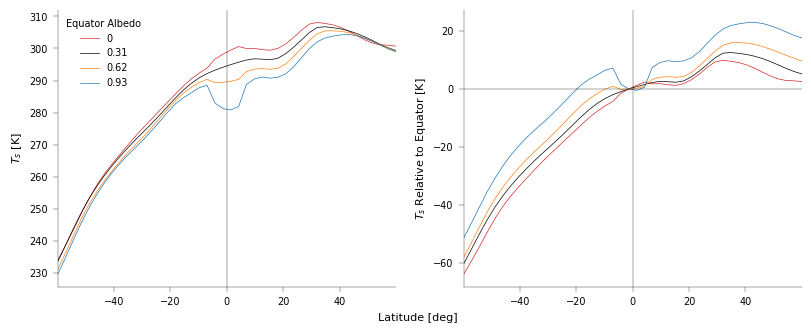

In [9]:
plot_var('t_surf', '$T_s$', 'K');

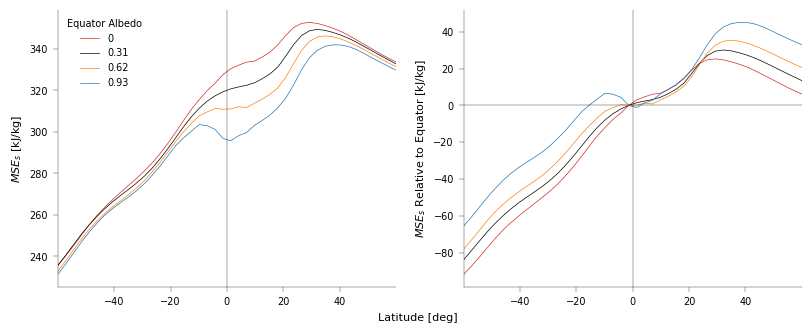

In [10]:
plot_var('mse_surf', '$MSE_s$', 'kJ/kg');

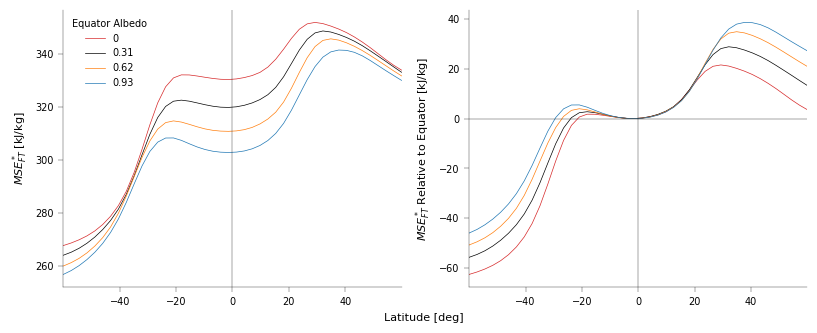

In [11]:
fig, ax = plot_var('mse_ft_sat', '$MSE^*_{FT}$', 'kJ/kg')

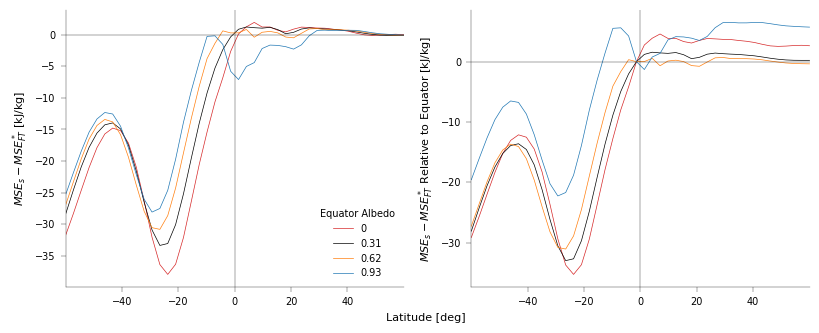

In [12]:
fig, ax = plot_var('mse_lapse', '$MSE_s - MSE^*_{FT}$', 'kJ/kg')
ax[0].axhline(0, color='k', lw=ax_linewidth);